# Customer Segmentation using Various Clustering Techniques
***

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

/Applications/anaconda3/lib/python3.7/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
df = pd.merge(df_offers,df_transactions)
df.head()


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [5]:
df_pt= pd.pivot_table(df, values= "n", index= "customer_name", columns = "offer_id", fill_value=0)
df_pt.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


***
## K-Means Clustering

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

## Results:
* Smaller sums of squares will represent better clusters because they are tighter clusters.
* Intertia Graph:
> * There was no recognizable spot where the SS leveled out. For thoroughness, I even tested K = 14 which is far too many clusters for the 100 customers in our dataset. However, this still did not produce a spot where the SS results leveled out. Perhaps this is due to the shape of the data.
>>* *To investigate this further, I created a scatter plot to see how the data visually looked*
>> * This is indeed the case. When looking at the shape of the scatter plot, it is very difficult to figure out the best number for k
* Conclusions: 
> * based on the scatter & the inertia plot, I would guess the best number of clusters is around 5 or 6
> * however, when dealing with skewed data points, the inertia plot is not the best solution for predicting k (number of clusters)
* Bar Graphs:
> * It is helpful to see the distribution of the number of customers in each cluster based on the number of clusters
> * PROBLEM: *you cannot base any decisions off these bar graphs because KMeans starts with a random value. Therefore, you will come up with different answers each time you compute the bar graphs. In order to combat this, it would be wise to use cross validation.

In [6]:
x_cols = df_pt.values
x_cols

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

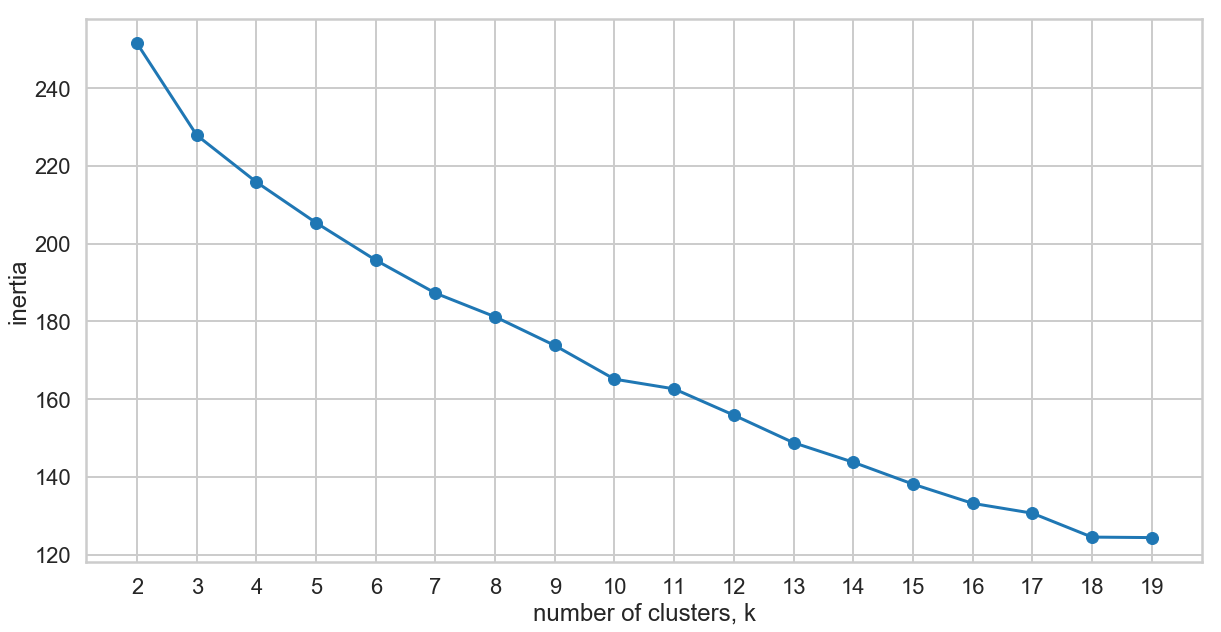

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

ks = range(2, 20) #this is the range of clusters you want to try
inertias = [] #empty list

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans( n_clusters= k)

    # Fit model to samples
    #SAMPLES IS AN ARRAY OF MEASUREMENTS FOR GRAIN
    model.fit(x_cols)

    # Append the inertia to the list of inertias so you can graph later on
    inertias.append(model.inertia_)

# Plot numeber of clusters vs inertias
plt.figure(figsize=(20,10))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [8]:
#Turning all the names into numerical respresentations so I can create a scatter plot of the data
new_df= pd.DataFrame(pd.factorize(df.values.T.reshape(-1,))[0].reshape(df.shape[1], -1), index=df.columns).T

#double checking this transformation worked:
df[df.customer_name == "Thomas"] #6 results
new_df[new_df.customer_name == 89]# 6 results

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,0,32,44,53,55,79,88,89,0
26,3,33,47,53,56,79,0,89,0
93,8,35,50,54,61,82,88,89,0
110,10,36,47,53,63,79,88,89,0
136,13,37,51,53,66,82,88,89,0
237,25,41,45,54,64,83,88,89,0


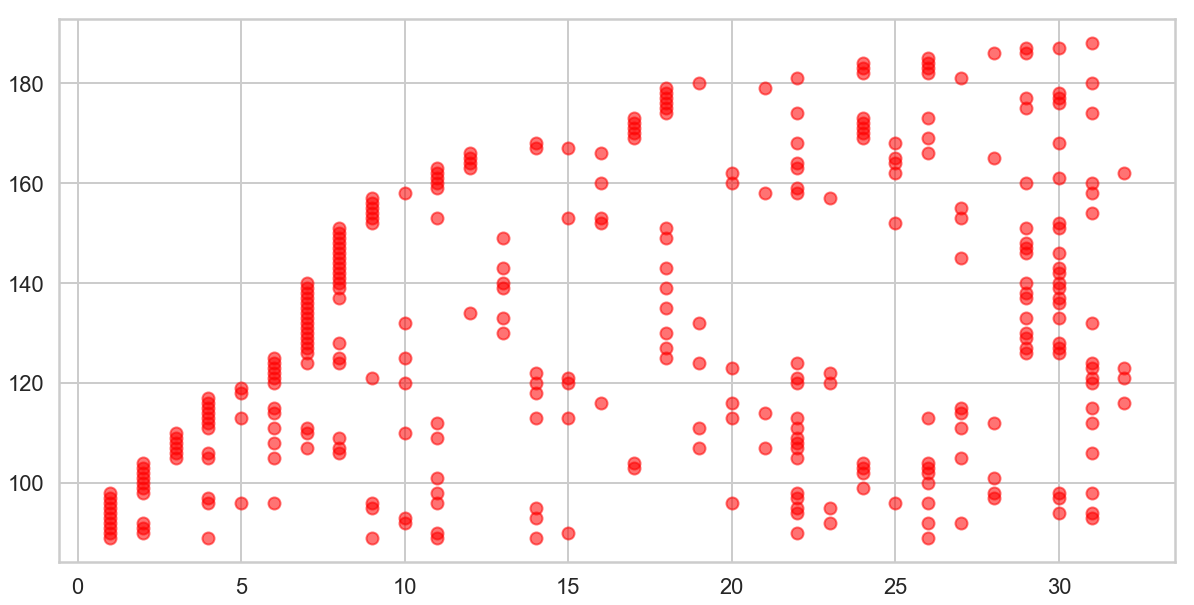

In [9]:
#below is a scatter plot of what the data actually looks like
xs =df.iloc[:,:1].values
ys= new_df.customer_name.values
plt.figure(figsize=(20,10))
plt.scatter(xs, ys, c= "r", alpha= .55)

Text(0, 0.5, '# of Customers per Cluster')

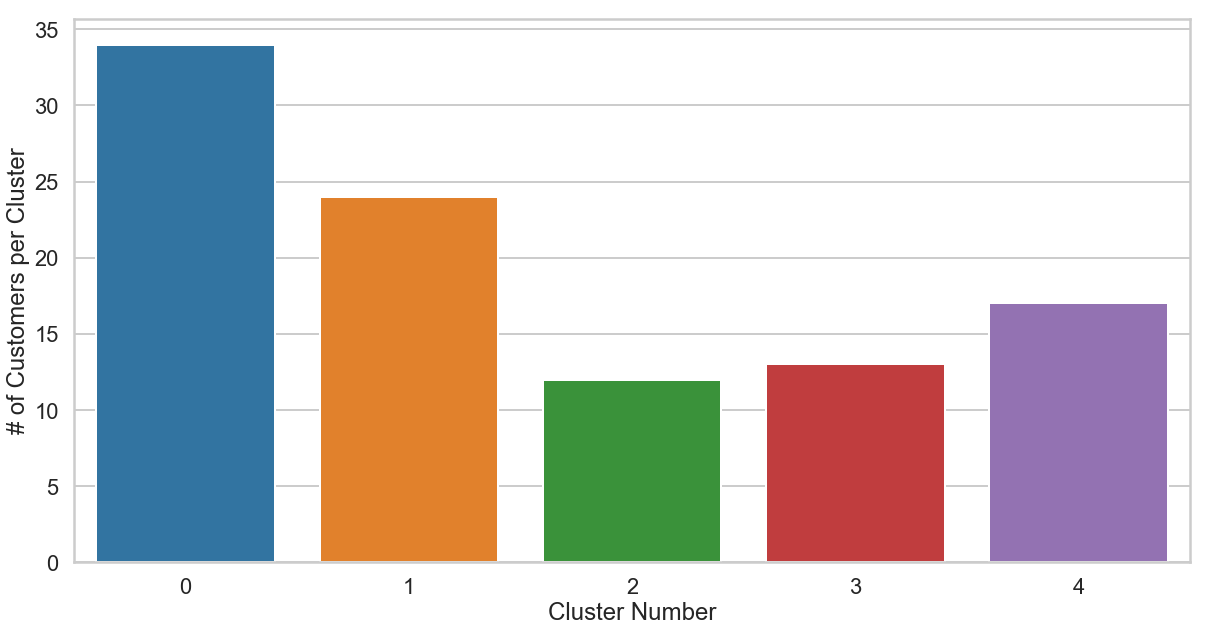

In [10]:
#Creating a bar graph with 6 clusters to see how they are distributed

model = KMeans(n_clusters= 5)
model.fit(x_cols)
df_pt["cluster"] = model.labels_
labels = model.labels_
bar_info = pd.DataFrame(labels)
plt.figure(figsize=(20,10))
sns.countplot(x=0, data= bar_info)
plt.xlabel("Cluster Number")
plt.ylabel("# of Customers per Cluster")

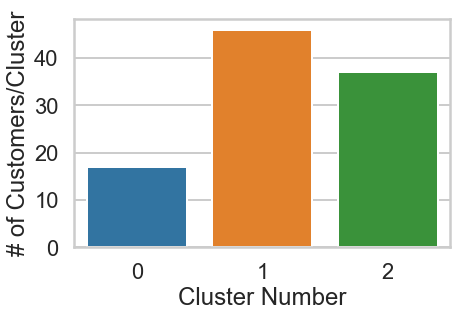

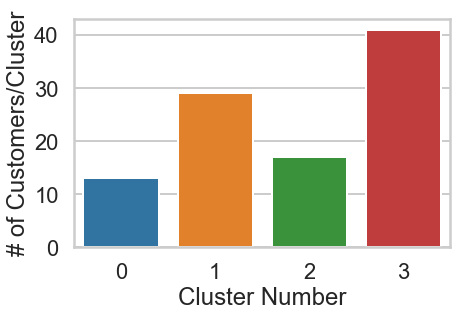

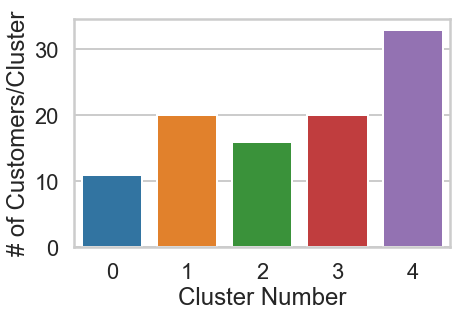

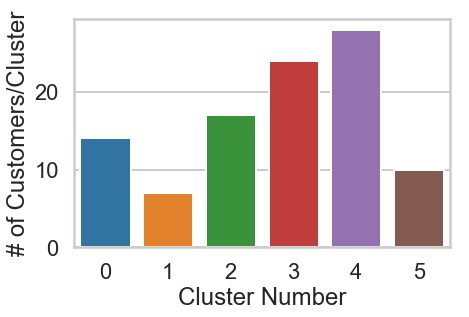

In [11]:
#Iterating through cluster numbers 3-6 to see how their distributions look

ks = range(3, 7) #this is the range of clusters you want to try
inertias = [] #empty list

for k in ks:
    n = k-2
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters= k)

    # Fit model to samples
    #SAMPLES IS AN ARRAY OF MEASUREMENTS FOR GRAIN
    model.fit(x_cols)
    
    #gathering the number from the clusters
    labels = model.labels_
    bar_info = pd.DataFrame(labels)

    # graph the plots
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,n)
    sns.countplot(x=0, data= bar_info)
    plt.xlabel("Cluster Number")
    plt.ylabel("# of Customers/Cluster")
    plt.tight_layout()

***

### Choosing K: The Silhouette Method

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

## Results:
* The results from the silhouette didn't differ too much from the scatter or the inertia plot. All of the iterations of number of clusters indicate their structures are not substantial. 
* The "best" number of clusters is 5, which is what we estimated using the scatter and inertia plot. However, these silhouette scores are not statistically significant. They are all so close in value, and moreover none of them represent truly good cluster formations.

In [12]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

For n_clusters = 2 The average silhouette_score is : 0.09365573283492713
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12347053919571699
For n_clusters = 5 The average silhouette_score is : 0.14092516241984757
For n_clusters = 6 The average silhouette_score is : 0.1371798939109807


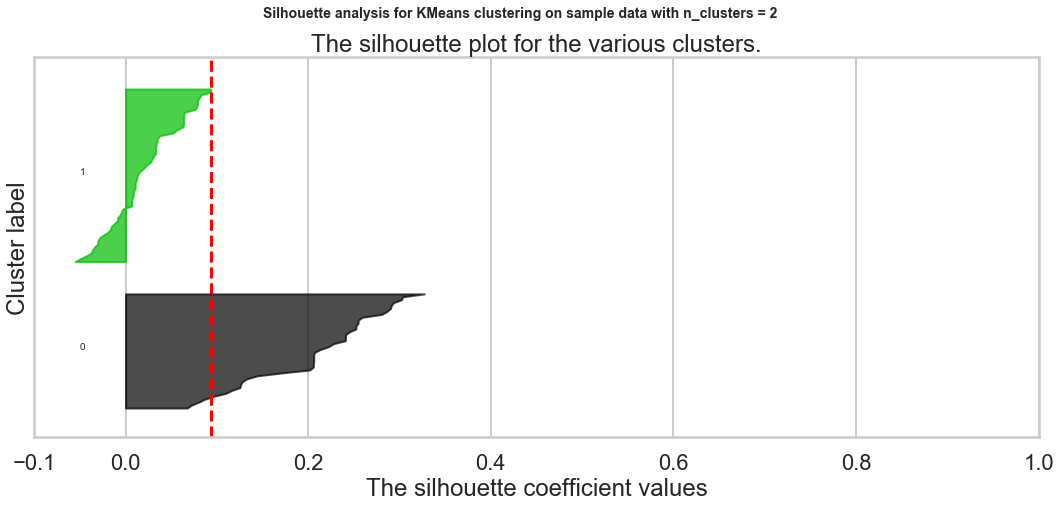

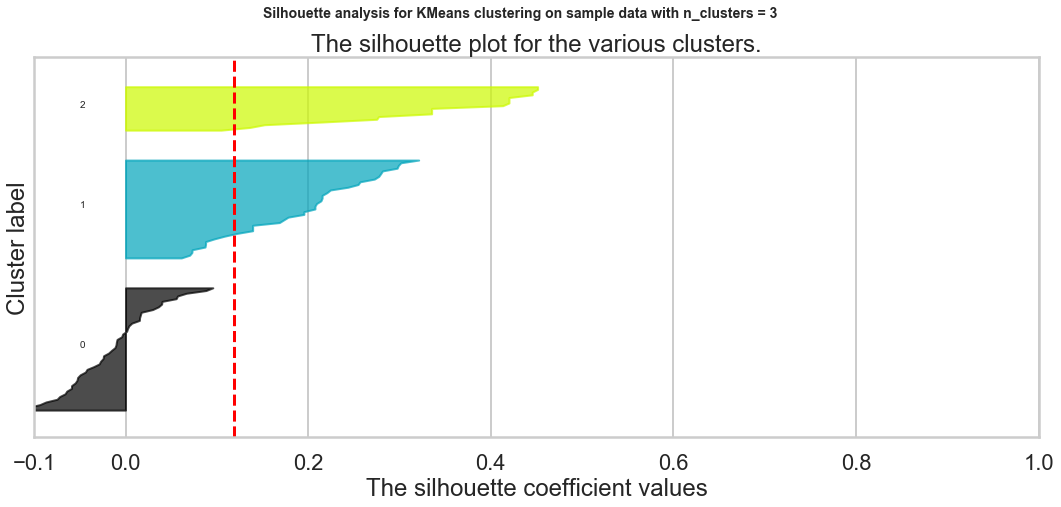

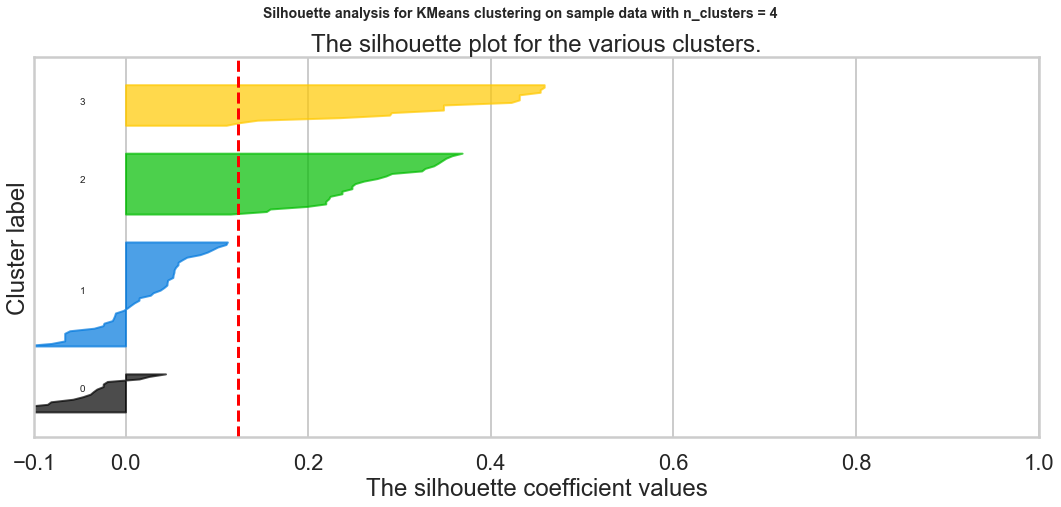

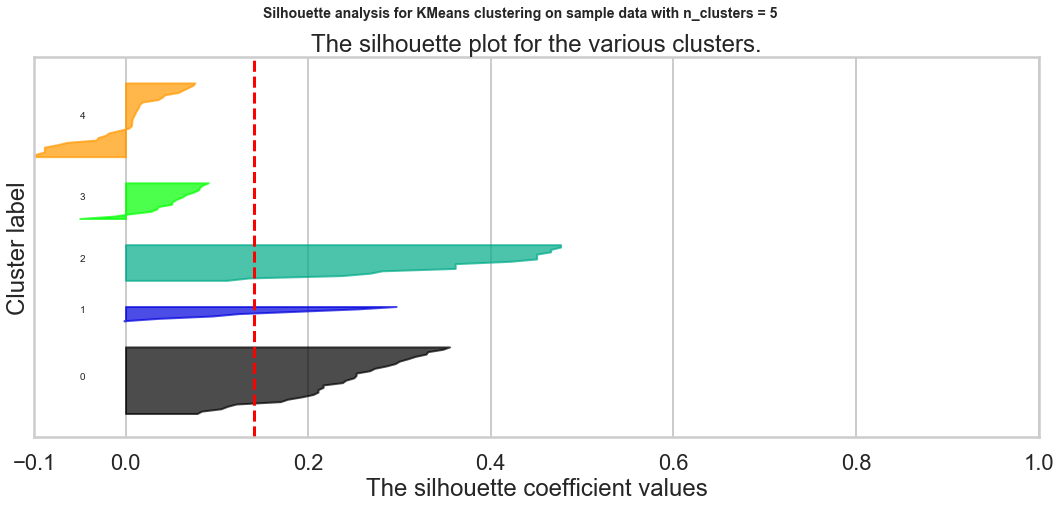

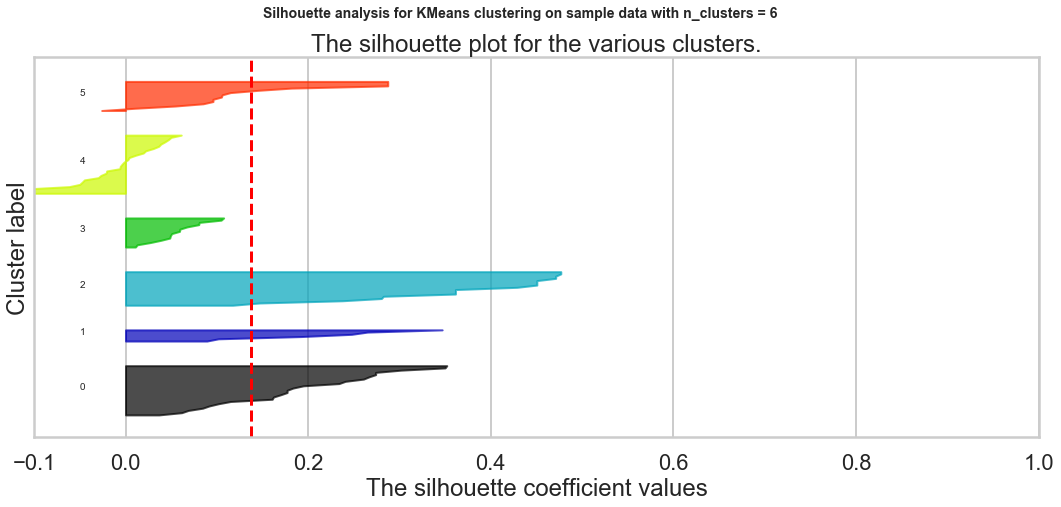

In [13]:
range_n_clusters = [2, 3, 4, 5, 6]
averages = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    averages.append(silhouette_avg)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


Text(0, 0.5, 'Silhouette Average')

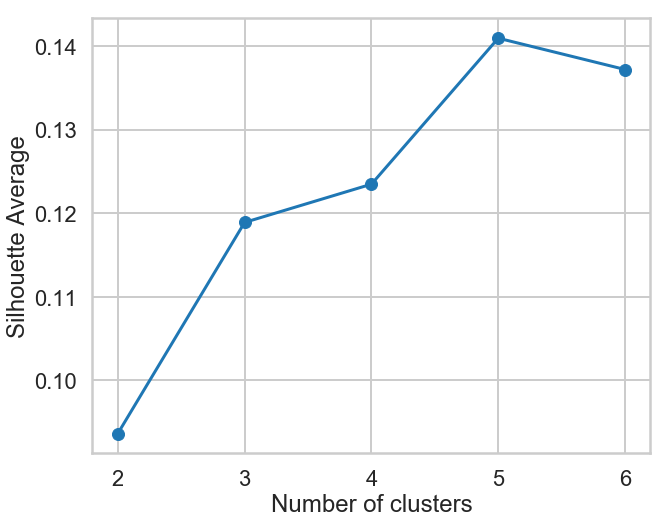

In [14]:
#Graph showing the slight increase of Silhouette Average... Again these are not good silhouette values to start with
averages
num_clusters = [2, 3, 4, 5, 6]
plt.figure(figsize=(10,8))
plt.plot(num_clusters,averages, marker= "o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Average")

***
### Choosing $K$: The Gap Statistic

The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

***
## Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

***
## Visualizing Clusters using PCA

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

## Results:
* The clusters still look a bit intertwined, but better than other K-values
* the silhouette method was the most accurate with this dataset in choosing the best K

In [15]:
# Import PCA
from sklearn.decomposition import PCA
import scipy
from scipy.stats import pearsonr

# Create PCA instance: model
PCA = PCA()

# Apply the fit_transform method of model to grains: pca_features
pca_features = PCA.fit_transform(x_cols)

# Assign 0th column of pca_features: xs
xs = pca_features[:,0]

# Assign 1st column of pca_features: ys
ys = pca_features[:,1]


In [16]:
#creating a data frame out of the data
df_main= pd.DataFrame({"x": xs, "y":ys, "cluster": df_pt.cluster, "customer" : df_pt.index})
df_main= df_main.reset_index()
df_main= df_main.drop(columns="customer")

Text(0.5, 1.0, 'PCA of the Different Clusters')

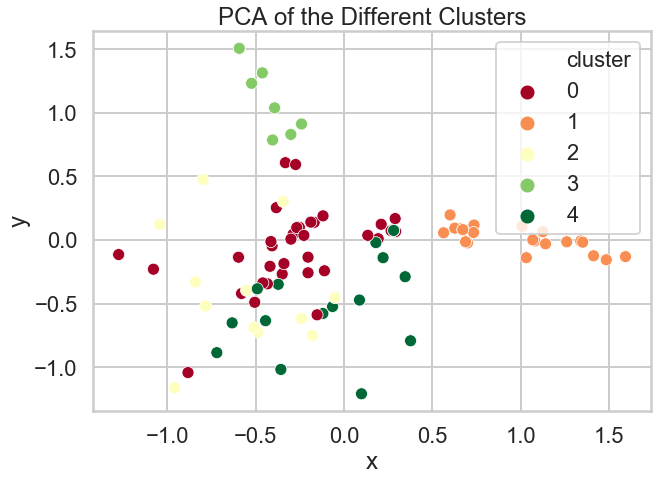

In [17]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="x", y="y", data= df_main, hue= "cluster", legend= "full", palette= "RdYlGn")
plt.title("PCA of the Different Clusters")


## FINDINGS FROM THE CLUSTERS

It is all good and well to find the clusters, but what useful information can be extracted from these clusters?

* Cluster 0 is by far the highest purchasing cluster so if you need to market to anyone, you should market to them
* March and December sell the most wine packages 
>* Cluster 1 buys the most wine in March, so a targeted marketing campaign in March to this cluster could help boost sales
>* Clusters 0,1,2 all buy large quantities of wine packages in December so a mass marketing campaign for the holidays would help boost sales
> * Cluster 3 tends to purchase in the fall months and they are biggest Pinot Grigio consumers. Thus, a target Pinot Grigio campaign in the fall could help increase the sales from cluster 3.
* Champagne is the highest varietal seller, and cluster 0 purchases the most champagne
* Cluster 0 orders mostly Champagne and Pinot Noir. Thus, a package with Champagne and Pinot Noir in the months of March would be a good target to the highest purchasing segment

In [18]:
df_final= pd.merge(df,df_main, on= "customer_name")
df_final.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,x,y,cluster
0,1,January,Malbec,72,56,France,False,Thomas,1,-1.041879,0.122314,2
1,4,February,Champagne,72,48,France,True,Thomas,1,-1.041879,0.122314,2
2,9,April,Chardonnay,144,57,Chile,False,Thomas,1,-1.041879,0.122314,2
3,11,May,Champagne,72,85,France,False,Thomas,1,-1.041879,0.122314,2
4,14,June,Merlot,72,64,Chile,False,Thomas,1,-1.041879,0.122314,2


Text(0.5, 1.0, 'Which cluster orders the most packages?')

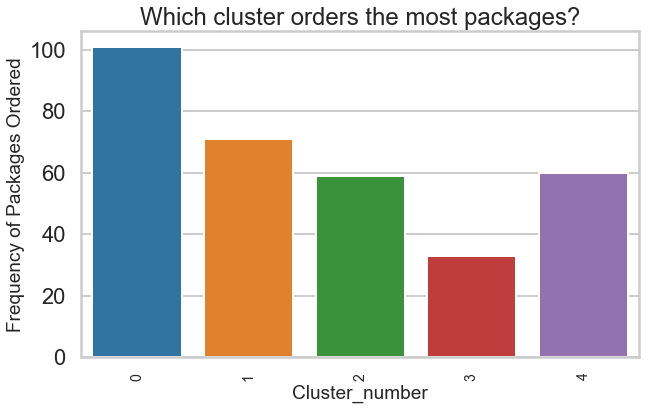

In [19]:
#which clusters buy the most in general?
clust= df_final.groupby("cluster")["n"].count().sort_values(ascending= False)
plt.figure(figsize=(10,6))
sns.barplot(clust.index, clust)
plt.xticks(rotation=90, fontsize= 14)
plt.xlabel("Cluster_number", fontsize= 19)
plt.ylabel("Frequency of Packages Ordered", fontsize= 19)
plt.title("Which cluster orders the most packages?")


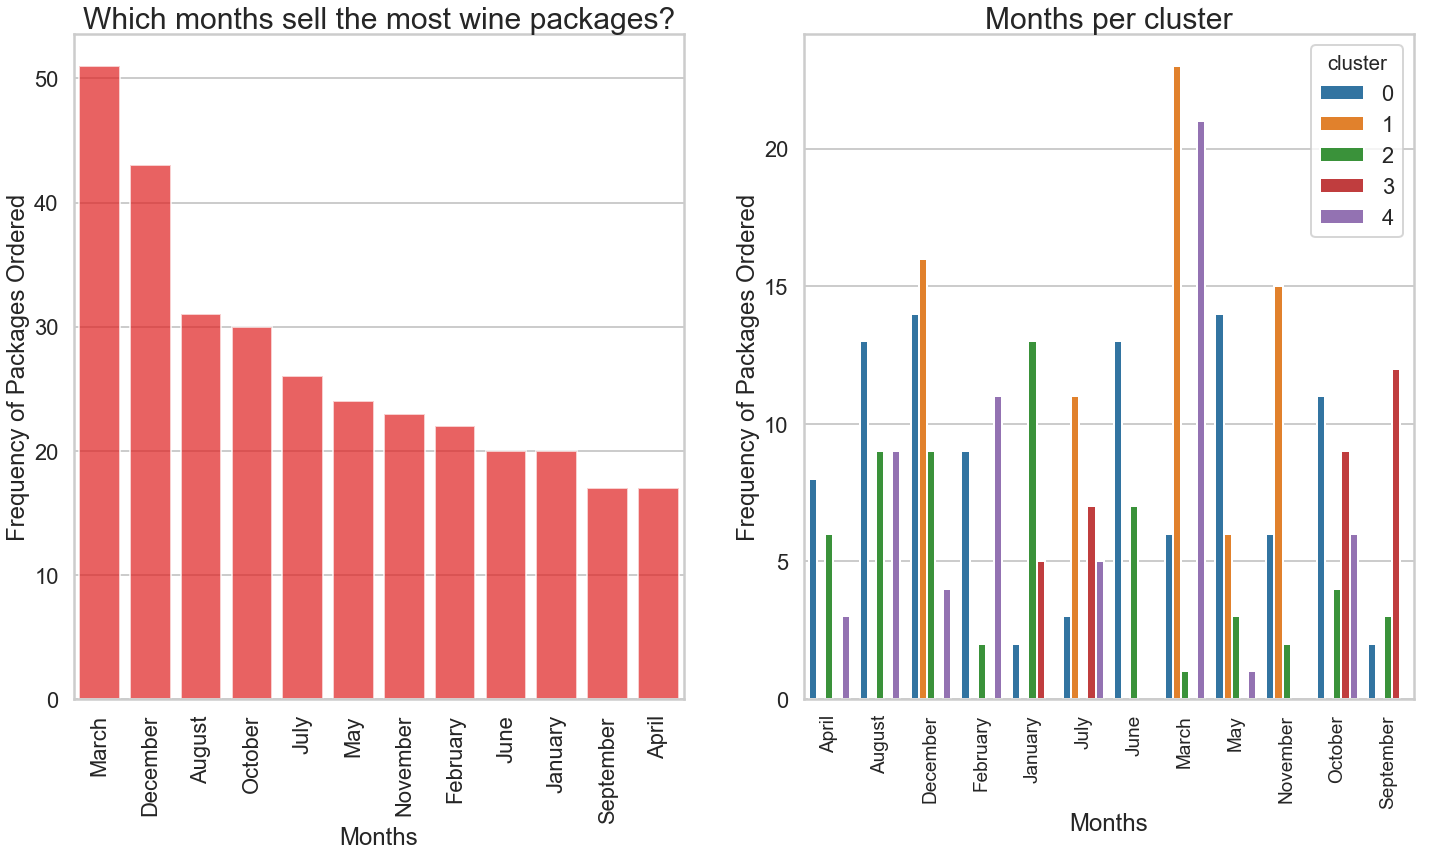

In [20]:

#which campaign months perform the best?
months= df_final.groupby("campaign")["n"].count().sort_values(ascending= False)
f, axes = plt.subplots(1, 2, figsize=(20,12))
sns.barplot(months.index, months, ax= axes[0], color= "r", alpha= .7)
axes[0].set_xticklabels(months.index, rotation=90)
axes[0].set_title("Which months sell the most wine packages?", fontsize=30)
axes[0].set_xlabel("Months", fontsize= 24)
axes[0].set_ylabel("Frequency of Packages Ordered", fontsize= 24)

#Cluster per campaign
campaign_cluster= df_final.groupby(["campaign", "cluster"])["n"].count().reset_index(name="count")
sns.barplot(x="campaign", y= "count", data= campaign_cluster, hue= "cluster", ax= axes[1])
plt.xticks(rotation=90, fontsize= 19)
plt.xlabel("Months", fontsize= 24)
plt.ylabel("Frequency of Packages Ordered", fontsize= 24)
plt.title("Months per cluster", fontsize= 30)

plt.tight_layout()



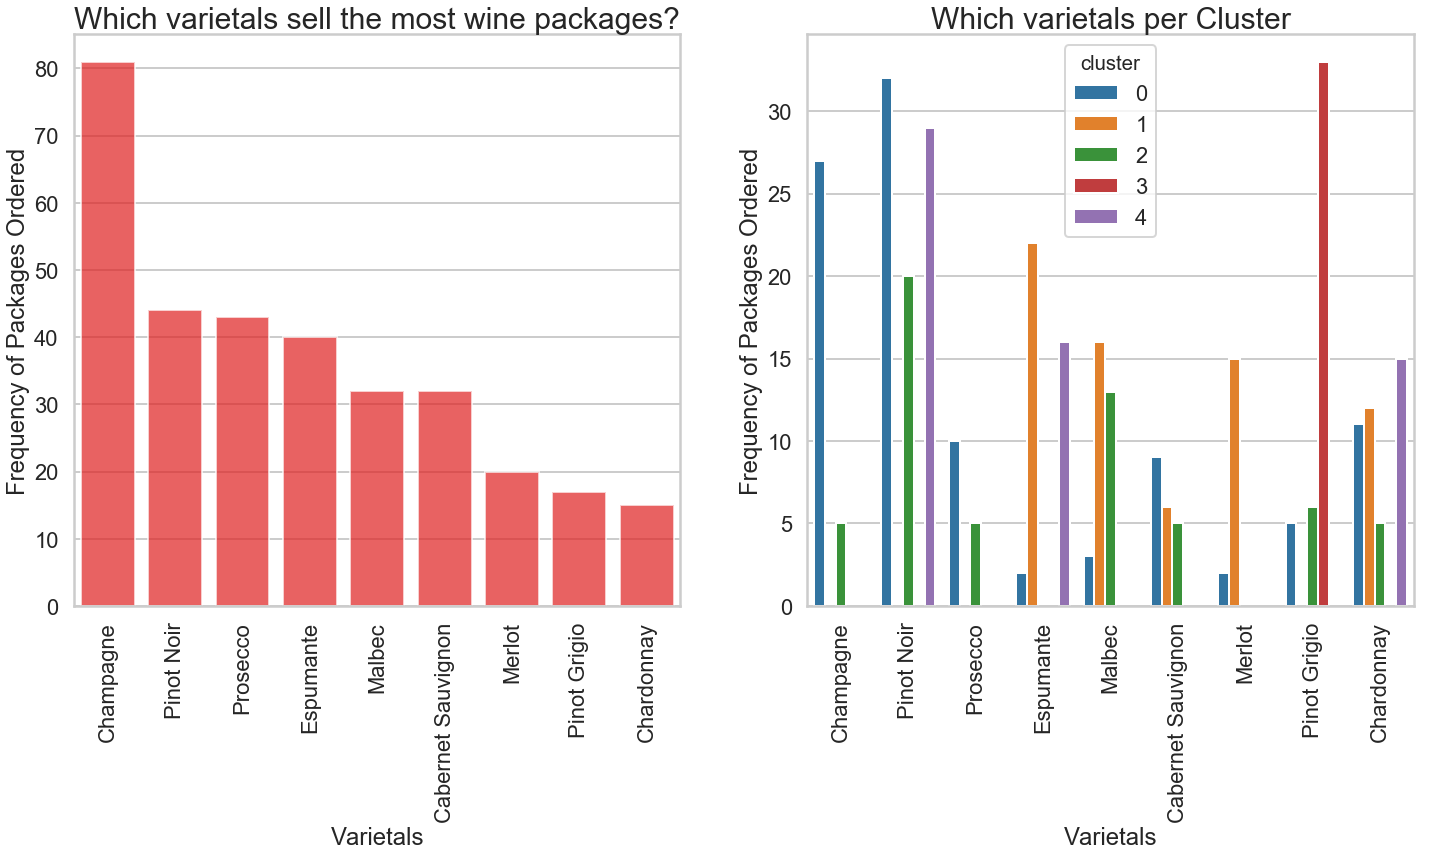

In [21]:

#which campaign months perform the best?
var= df.groupby("varietal")["n"].count().sort_values(ascending= False)
f, axes = plt.subplots(1, 2, figsize=(20,12))
sns.barplot(var.index, var, ax= axes[0], color= "r", alpha= .7)
axes[0].set_xticklabels(var.index, rotation=90)
axes[0].set_title("Which varietals sell the most wine packages?", fontsize=30)
axes[0].set_xlabel("Varietals", fontsize= 24)
axes[0].set_ylabel("Frequency of Packages Ordered", fontsize= 24)

#Cluster per campaign
#Cluster per varietal
varietal_cluster= df_final.groupby(["varietal", "cluster"])["n"].count().reset_index(name="count")
sns.barplot(x="varietal", y= "count", data= varietal_cluster, hue= "cluster", ax= axes[1])
axes[1].set_xticklabels(var.index, rotation=90)
axes[1].set_title("Which varietals per Cluster", fontsize=30)
axes[1].set_xlabel("Varietals", fontsize= 24)
axes[1].set_ylabel("Frequency of Packages Ordered", fontsize= 24)

plt.tight_layout()

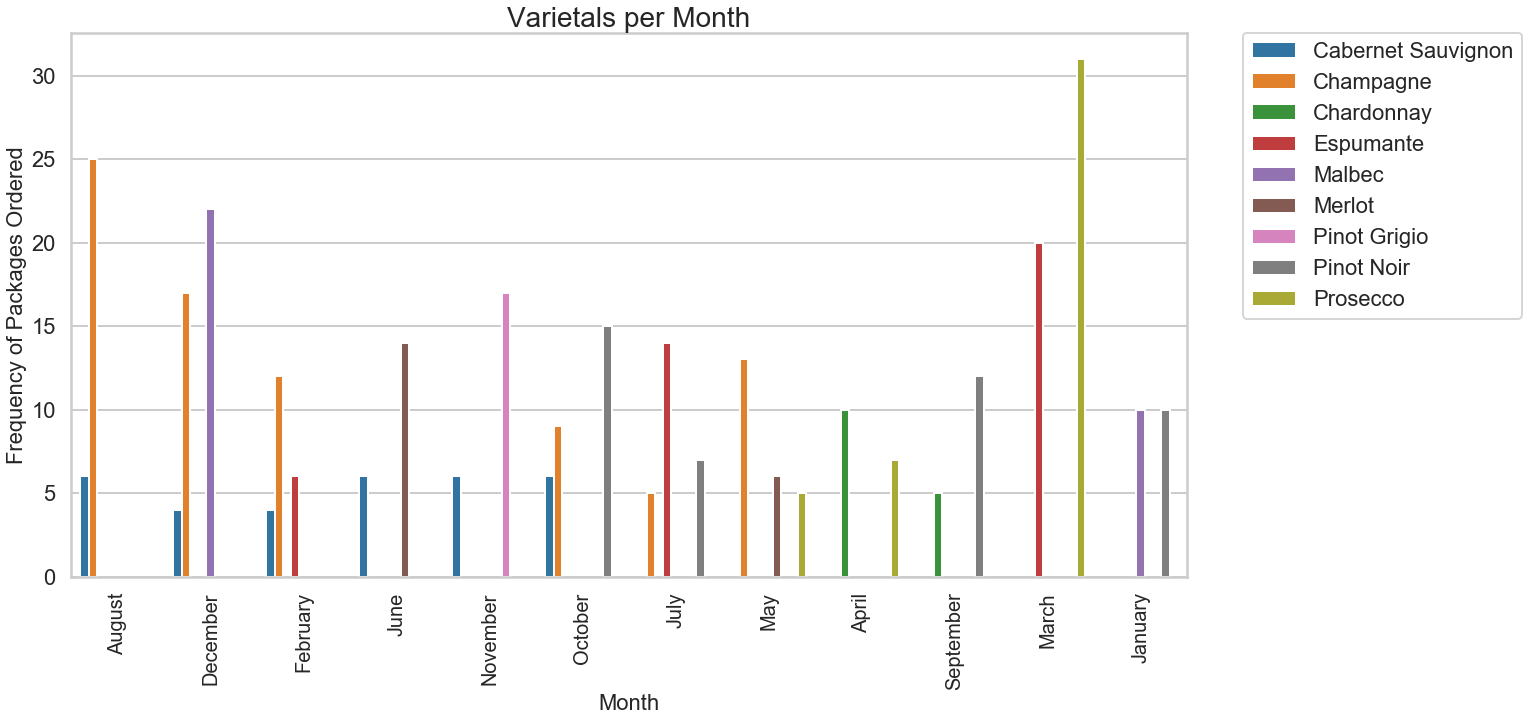

In [22]:
#Wine Varietals Per Month
varietal_month= df_final.groupby(["varietal", "campaign"])["n"].count().reset_index(name="count")
plt.figure(figsize=(20,10))
sns.barplot(x="campaign", y= "count", data= varietal_month, hue= "varietal")
plt.xticks(rotation=90, fontsize= 20)
plt.title("Varietals per Month", fontsize=28)
plt.xlabel("Month", fontsize= 22)
plt.ylabel("Frequency of Packages Ordered", fontsize= 22)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

## Results:
* The optimal number of dimensions is 3 based on the graph below
* I tested this out using PCA and the scatter plot, and it indeed looks like three features or dimensions more clearly segments out the different groups

In [23]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

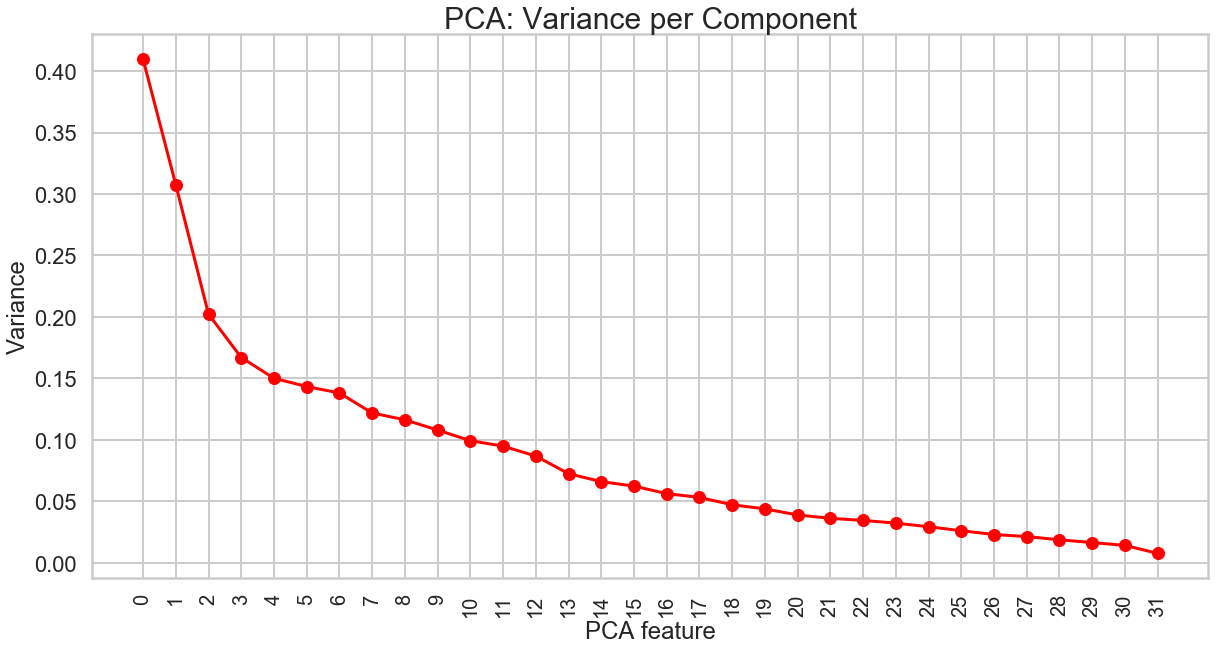

In [24]:
# Plot the explained variances
features = range(pca.n_components_)
plt.figure(figsize=(20,10))
plt.plot(features, pca.explained_variance_, color= "r", marker='o')
plt.xticks(rotation=90, fontsize= 20)
plt.xlabel('PCA feature', fontsize= 24)
plt.ylabel('Variance', fontsize= 24)
plt.xticks(features)
plt.title("PCA: Variance per Component", fontsize= 30)
plt.show()

Text(0.5, 1.0, 'PCA of the Different Clusters')

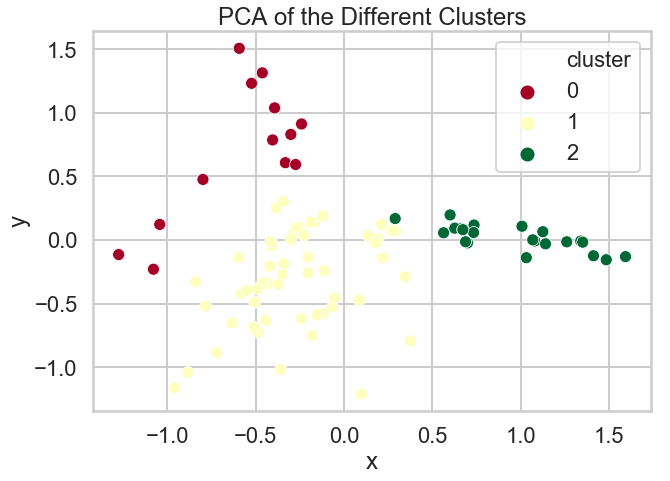

In [25]:
from sklearn.decomposition import PCA

#Trying out Kmeans with 3 clusters 
model = KMeans(n_clusters= 3)
model.fit(x_cols)
df_pt["cluster2"] = model.labels_

# Create PCA instance: model
PCA = PCA()

# Apply the fit_transform method of model to grains: pca_features
pca_features = PCA.fit_transform(x_cols)

# Assign 0th column of pca_features: xs
xs = pca_features[:,0]

# Assign 1st column of pca_features: ys
ys = pca_features[:,1]


#creating a data frame out of the data
df_main= pd.DataFrame({"x": xs, "y":ys, "cluster": df_pt.cluster2, "customer" : df_pt.index})
df_main= df_main.reset_index()
df_main= df_main.drop(columns="customer")

#Creating a scatter plot
plt.figure(figsize=(10,7))
sns.scatterplot(x="x", y="y", data= df_main, hue= "cluster", legend= "full", palette= "RdYlGn")
plt.title("PCA of the Different Clusters")

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### Affinity Propagation Results:
* AP seems to be a below average tool for clustering. It definitely needed some parameter tuning because with the default parameters it grouped 14 different clusters! However, when I tuned the parameters and got a lower number of clusters the silhouette metric also went down. The highest silhouette method was with 18 clusters!
* To view the different clusters results see the graphs below. The graphs evolve to get more accurate as the preference parameter gets smaller. However, there is a threshold at -30 where it groups the data too aggressively at only 2 clusters.
* Although, once I tuned the parameters AF was very accurate, my hesitation in using this algorithm is that I already had an intuitive sense of the best way to cluster this data, and I don't think I would get that from the initial graph. 
* Also, if you view when pref= -25 with 3 clusters, the clusters are not very good.
* Kmeans can be bothersome figuring out the K ahead of time, however this algorithm didn't provide an accurate "out of the box" alternative.

In [26]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

#Getting the components from PCA
comp = sklearn.decomposition.PCA(n_components=2).fit_transform(x_cols)
components = pd.DataFrame(comp)
components.columns=['x','y']

# Compute Affinity Propagation
preference= [None, -5, -15, -25, -35]

def affinity_p(matrix, preference= None):
    for pref in preference:
        afp = AffinityPropagation(preference= pref)
        predict= afp.fit_predict(matrix)#x_cols is the original matrix we created of responses to the wine promotions
        n_clusters_ = len(afp.cluster_centers_indices_)
        centers= afp.cluster_centers_

        #Printing out the information:
        print (f"INFORMATION FOR PREFERENCE = {pref}")
        print(f"Estimated number of clusters: {n_clusters_}")
        print(f"Silhouette Coefficient: {metrics.silhouette_score(matrix, predict): .3f}")
        
        #Plotting the scatter plot
        plt.figure(figsize=(8,6))
        sns.scatterplot(components.x, components.y, hue= predict, legend= "full", palette= "rainbow", alpha= .7)
        #plt.scatter(components.x, components.y, c= predict, cmap='rainbow', alpha=0.7)
        plt.title(f"Affinity Propagation Clusters with Pref= {pref}")
        
#         # Plotting the centers of the clusters
#         centers_x = centers[:,0]
#         centers_y = centers[:,1]
#         plt.scatter(centers_x, centers_y,c= "k",s=250, marker= "D", alpha= .75)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.show()
        

INFORMATION FOR PREFERENCE = None
Estimated number of clusters: 14
Silhouette Coefficient:  0.123


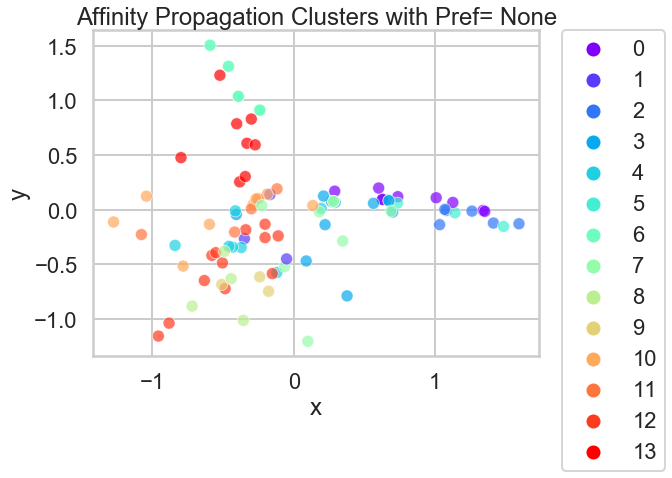

INFORMATION FOR PREFERENCE = -5
Estimated number of clusters: 18
Silhouette Coefficient:  0.136


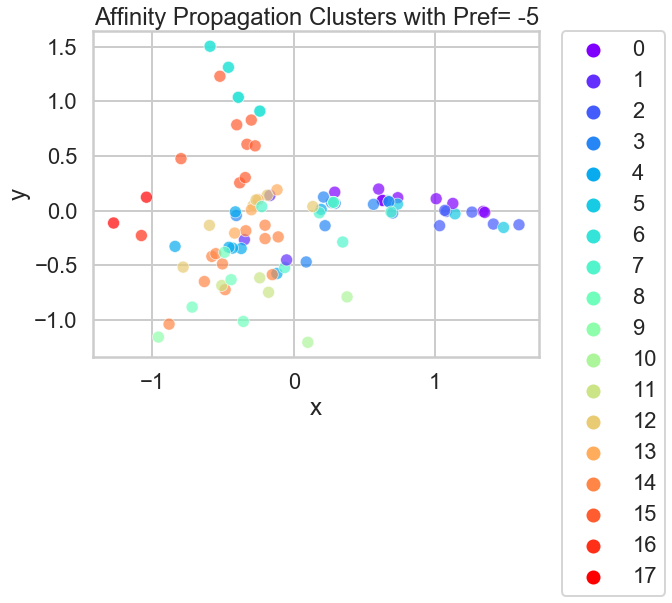

INFORMATION FOR PREFERENCE = -15
Estimated number of clusters: 5
Silhouette Coefficient:  0.094


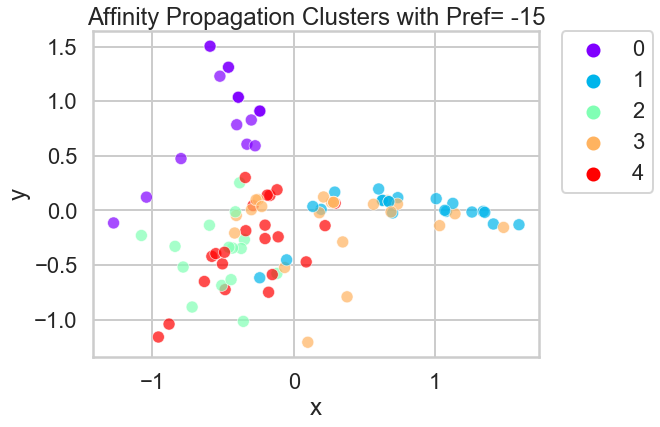

INFORMATION FOR PREFERENCE = -25
Estimated number of clusters: 3
Silhouette Coefficient:  0.072


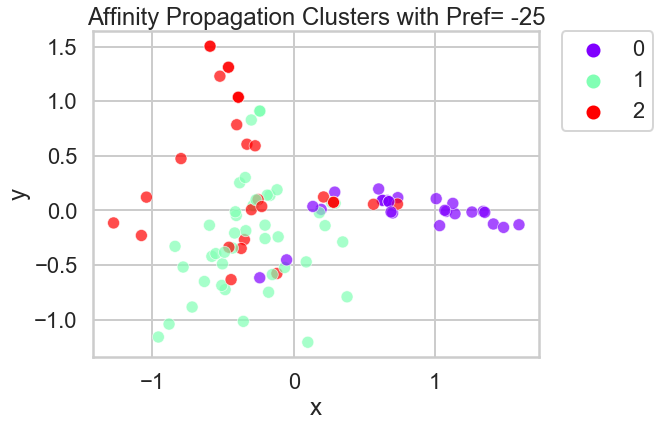

INFORMATION FOR PREFERENCE = -35
Estimated number of clusters: 2
Silhouette Coefficient:  0.080


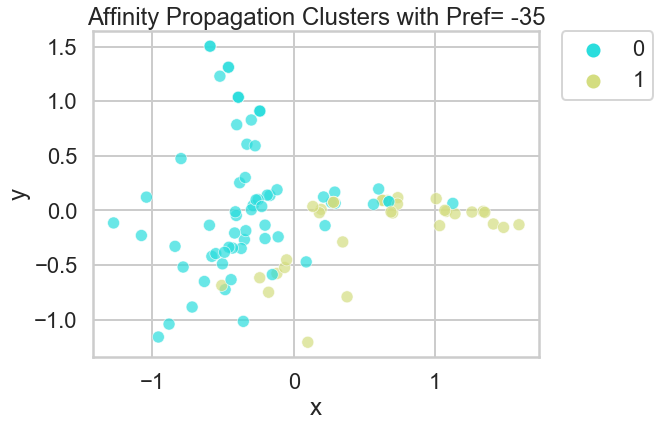

In [27]:
affinity_p(x_cols, preference)

### Spectral Clustering Results:
* Spectral seems to be very comparable to K-Means where you need to know the number of clusters ahead of time. However, it seems to very accurate if you get the correct number of clusters.
* The silhouette average seems to have gone up as well!

silhouette_avg: 0.17043536840380896


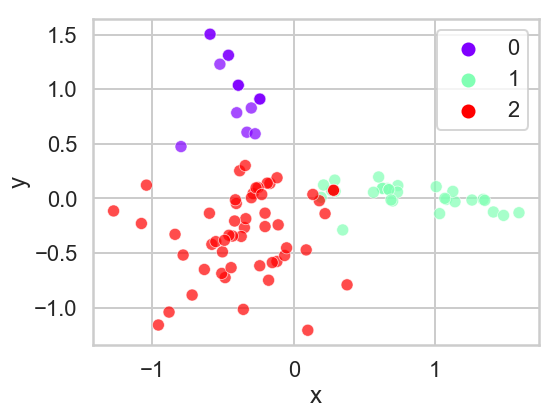

In [28]:
from sklearn.cluster import SpectralClustering

SC = SpectralClustering(n_clusters=3, assign_labels="discretize", random_state=0).fit(x_cols)
labels= SC.labels_
print (f"silhouette_avg: {silhouette_score(x_cols, labels, metric='sqeuclidean')}")
plt.figure(figsize=(8,6))
sns.scatterplot(components.x, components.y, hue= labels, legend= "full", palette= "rainbow", alpha= .7)


### Agglomerative Clustering Results:
* Its always a good idea to look at the dendrogram first to see where the best cluster cut offs would be.
>* You can see the hold up with splitting the clusters is coming from the right side group. This group could easily create 3, 5, or 6 clusters depending where you cut off the height of the dendrogram. You could test out different clusters on your customers, and see if it makes logical sense to split the group to the right up, or keep them together.

* Agglomerative seems to preform very similar to spectral clustering; however, agglomerative gets higher silhouette values.
* Also, I would be curious to not providing a K for agglomerative, and seeing what the algorithm can come up with.

*In the future I will most likely choose agglomerative or spectral because the higher performance value*

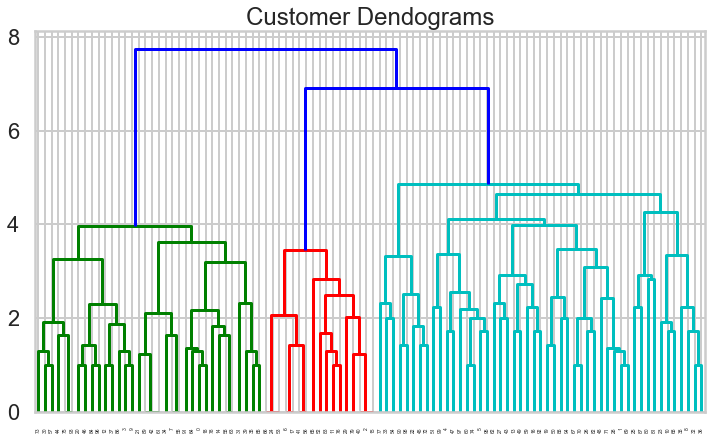

In [29]:
#SUPER helpful to view the dendrogram of a dataset to see how the clusters are formed.
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(12, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(x_cols, method='ward'))

silhouette_avg: 0.1734505160934133


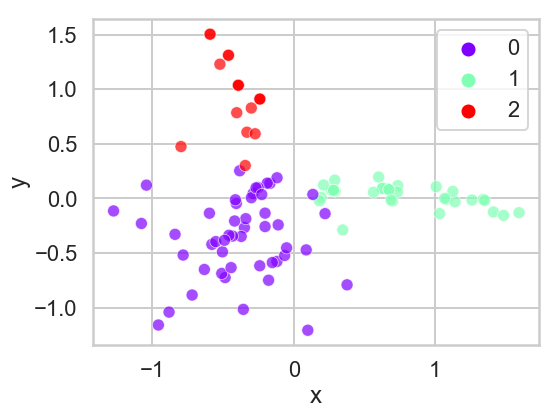

In [30]:
from sklearn.cluster import AgglomerativeClustering

AC = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
label= AC.fit_predict(x_cols)
print (f"silhouette_avg: {silhouette_score(x_cols, label, metric='sqeuclidean')}")
plt.figure(figsize=(8,6))
sns.scatterplot(components.x, components.y, hue= label, legend= "full", palette= "rainbow", alpha= .7)


silhouette_avg: 0.21883039021872147


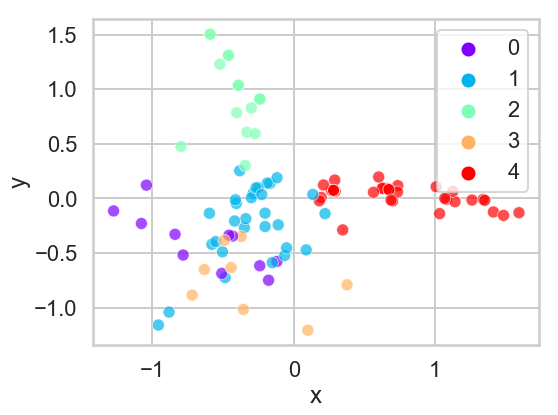

In [31]:
from sklearn.cluster import AgglomerativeClustering

AC = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
label= AC.fit_predict(x_cols)
print (f"silhouette_avg: {silhouette_score(x_cols, label, metric='sqeuclidean')}")
plt.figure(figsize=(8,6))
sns.scatterplot(components.x, components.y, hue= label, legend= "full", palette= "rainbow", alpha= .7)


### DBSCAN Results:
* DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
* What is it?
>* is a clustering method that is used in machine learning to separate clusters of high density from clusters of low density. Given that DBSCAN is a density based clustering algorithm, it does a great job of seeking areas in the data that have a high density of observations, versus areas of the data that are not very dense with observations. DBSCAN can sort data into clusters of varying shapes as well, another strong advantage. 
>* DBSCAN does NOT necessarily categorize every data point, and is therefore terrific with handling outliers in the dataset.
* Disadvantages of DBSCAN:
>* Does not work well when dealing with clusters of varying densities. While DBSCAN is great at separating high density clusters from low density clusters, DBSCAN struggles with clusters of similar density.
>* Struggles with high dimensionality data. I know, this entire article I have stated how DBSCAN is great at contorting the data into different dimensions and shapes. However, DBSCAN can only go so far, if given data with too many dimensions, DBSCAN suffers
* Parameters:
>* eps : float, The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.
>* min_samples: The minimum samples allowed for one cluster to form.
* RESULTS:
>* You can see the result are not so good! I was only getting one cluster with various entries of epsilon and min_samples. I finally got a respectable amount of clusters, but look at the scatter plot below. It does not provide a lot of "good clusters"
* Why?
>* DBSCAN is a great method but really needs dense versus sparse clusters to be accurate and this dataset does not provide that.

[False False  True False False False False False False False False False
 False False False  True False False False False False False False False
  True False False False False False False False False False False False
 False False False False  True False  True False False False False False
 False False False False False  True False False False False False False
 False  True False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False]
The number of clusters are: 3
silhouette_avg: -0.2589303179017764


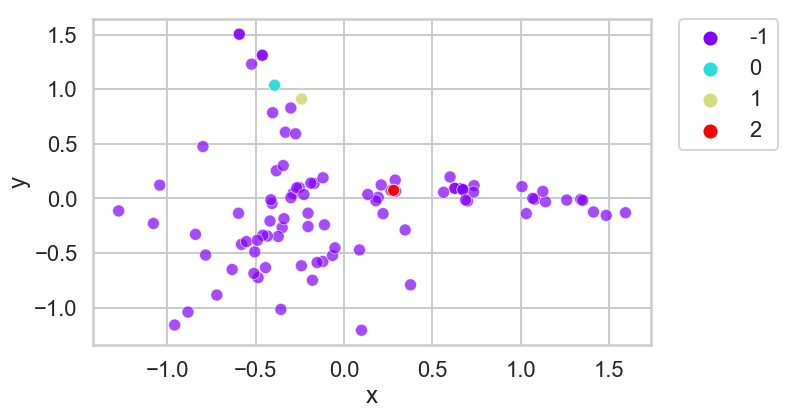

In [32]:
from sklearn.cluster import DBSCAN
db = DBSCAN(min_samples= 3)
model= db.fit(x_cols)
labelss = model.labels_

#Identify the core samples
core_samples= np.zeros_like(labelss, dtype= bool)
core_samples[db.core_sample_indices_]= True
print (core_samples)

#Count the number of clusters
n_clusters = len(set(labelss))- (1 if -1 in labelss else 0)
print(f"The number of clusters are: {n_clusters}")
#Silhoutte score
print (f"silhouette_avg: {silhouette_score(x_cols, labelss, metric='sqeuclidean')}")

#Graphing the results:
plt.figure(figsize=(10,6))
sns.scatterplot(components.x, components.y, hue= labelss, legend= "full", palette= "rainbow", alpha= .7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

## Conclusions:
* Different clustering algorithm are best suited for different types of information. For this small and spread out dataset, Agglomerative clustering seemed to work the best.
* However, the other clustering methods should not be discounted, because typically the sample size will be much larger than this.